In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
import uncertainties
from uncertainties import unumpy

In [37]:
def L3_neurons(): # We model L3 responses using the amplitude experimental analysis. 
    L3_amp_exp = np.loadtxt("Data/L3_Amp_exp.txt") #Amplitude of L3 responses from experimnts. 
    Slope_L3, Cut_L3  = np.polyfit(np.log10(L0_array), np.mean(L3_amp_exp, axis = 1), 1) #Linear fit of L3 response.
    time_array_st = np.arange(T_min_st, T_max_st, dt_st)
    St_epoch = np.sin(Omega_st*2*np.pi*time_array_st) 
    L3_time = np.zeros(Total_time_array_st.size)
    L3_time_epochs = np.zeros((Nl, Nt_st))
    Omega_ = 1 #(1Hz)
    Counter_il0 = -1
    for i_l0 in L0_array:
        Counter_il0 += 1
        L3_amp = np.log10((10**(Cut_L3))*((i_l0)**Slope_L3))
        L3_time[Nt_st*2*Counter_il0: Nt_st*2*Counter_il0 + Nt_st] = L3_amp*(St_epoch + 1) + baseline # Not need to multiply by 0.5 if we calculate the amp as max-min/2
        L3_time_epochs[Counter_il0, :] = L3_time[Nt_st*2*Counter_il0: Nt_st*2*Counter_il0 + Nt_st]
    return Slope_L3, Cut_L3, L3_time, L3_time_epochs

def Visualize_L3():
    Fig = plt.figure(figsize = (5, 3))
    L3_amp_exp = np.loadtxt("Data/L3_Amp_exp.txt")
    plt.plot(np.log10(L0_array) ,0.5*(np.max(L3_time_epochs, axis = 1) - np.min(L3_time_epochs, axis = 1)), color = 'k', linewidth = 2, label = 'Amplitude')
    plt.errorbar(np.log10(L0_array), np.mean(L3_amp_exp, axis = 1), yerr = np.std(L3_amp_exp, axis = 1)**2, color = 'b', alpha = 0.8, linewidth = 2, label='L3 responses')
    plt.plot(np.log10(L0_array), np.log10(L0_array)*Slope_L3 + Cut_L3, label = 'Linear fit')
    plt.legend(fontsize = 12)
    plt.xlabel("Luminance")
    plt.ylabel("L3 response Amplitude")
    plt.show()
    Fig = plt.figure(figsize = (5, 3))
    plt.plot(Total_time_array_st, L3_time, color = 'b')
    plt.xlabel("Time (s)")
    plt.ylabel("L3 response")
    #plt.savefig("Plots/L3_traces_example.pdf", bbox_inches = 'tight', dpi = 300)
    plt.show() 

In [28]:
def Spatial_pooling_L3(phase, Stim_circular_size, i_l0):
    space_array_st = np.arange(x_min_st, x_max_st, dx_st)
    St_epoch = np.sin(Omega_st_s*2*np.pi*space_array_st + 2*np.pi*phase) # One epoch at zero time with some random phase. 
    L3_amplitude = np.log10((10**(Cut_L3))*((i_l0)**Slope_L3))
    L3_epoch = L3_amplitude*(St_epoch + 1) + baseline - baseline # Baseline fron l3 and contraresting baseline from Dm. And 
    L3_f = np.repeat(np.reshape(L3_epoch, (1, Nx_st)), Nx_st, axis = 0)
    Screen_L3 = np.copy(L3_f)
    
    Nx_st_half =  int((x_max_st - x_min_st)/2)
    ratio = Stim_circular_size/2
    xx, yy = np.meshgrid(space_array_st, space_array_st)
    Circle_filter = (yy - Nx_st_half)**2 + (xx - Nx_st_half)**2 < ratio**2
    L3_f = np.where(Circle_filter, L3_f, 0.2)
    
    return L3_f, Screen_L3

def Normalization_L3():
    Respomse_Tm9_time = np.zeros((N_ite, Nl, Nstim, Nt_st))
    Amplitude = np.zeros((N_ite, Nl, Nstim))
    
    time_array_st = np.arange(T_min_st, T_max_st, dt_st)
    St_epoch = np.sin(Omega_st*2*np.pi*time_array_st)
    
    xx, yy = np.meshgrid(space_array_st, space_array_st)
    Dm_pooling = (yy - Nx_st_half)**2 + (xx - Nx_st_half)**2 < (Circular_pooling_size/2)**2 
    idx_pooling = np.where(np.reshape(Dm_pooling,  Nx_st*Nx_st))[0]
    Counter_l0 = -1
    for i_L0 in L0_array:
        Counter_l0 += 1
        counter_pooling = -1
        for Stim_circular_size in Stim_circular_array:
            counter_pooling += 1
            Mean = np.zeros(N_ite)
            for ite in range(N_ite):
                L3_pooled, Screen_L3 = Spatial_pooling_L3(np.random.uniform(), Stim_circular_size, i_L0)
                Mean[ite] = np.mean(np.reshape(L3_pooled, Nx_st*Nx_st)[idx_pooling])
                L3_ampl = np.log10((10**(Cut_L3))*((i_L0 - L3_num)**Slope_L3))
#                 Respomse_Tm9_time[ite, Counter_l0, counter_pooling,:] = (( ( ((L3_ampl)*(St_epoch + 1))) )**ExpNum/(g0 + alpha_norm*(Mean[ite])**ExpDen))
                Respomse_Tm9_time[ite, Counter_l0, counter_pooling,:] = (( ( ((L3_ampl)*(St_epoch)*0.5)) )**ExpNum/(g0 + alpha_norm*(Mean[ite])**ExpDen))
                Amplitude[ite, Counter_l0, counter_pooling] = (np.max(Respomse_Tm9_time[ite, Counter_l0, counter_pooling,:]) - np.min(Respomse_Tm9_time[ite, Counter_l0, counter_pooling,:]))/2
    return Respomse_Tm9_time, Amplitude

def Visualize_normalization_space():
    print("Fixed dm pooling size = "+str(Circular_pooling_size)+" degrees")
    Fig, ax = plt.subplots(1, 2, figsize = (13, 5))
    Grid = plt.GridSpec(1, 3)
    
    counter_pooling = -1
    for S_pooling in Stim_circular_array: 
        counter_pooling += 1
        alpha = 1/(counter_pooling + 1)
        ax[0].errorbar(L0_array, np.mean(Amplitude[:,:,counter_pooling], axis = 0), yerr = np.std(Amplitude[:,:,counter_pooling], axis = 0), label = 'St_size = '+str(S_pooling)+' d', marker = '.', alpha = alpha, color = 'teal')
        ax[1].errorbar(L0_array, np.mean(Amplitude[:,:,counter_pooling], axis = 0)/np.max(np.mean(Amplitude[:,:,counter_pooling], axis = 0)), np.std(Amplitude[:,:,counter_pooling], axis = 0)/np.max(np.mean(Amplitude[:,:,counter_pooling], axis = 0)), label = 'St ='+str(S_pooling)+' d', marker = '.', alpha = alpha)
#         ax[0].plot(L0_array, Amplitude[:,counter_pooling], label = 'St_size = '+str(S_pooling)+' d', marker = '.', alpha = alpha, color = 'teal')
#         ax[1].plot(L0_array, (Amplitude[:,counter_pooling])/np.max(Amplitude[:,counter_pooling]), label = 'St ='+str(S_pooling)+' d', marker = '.', alpha = alpha)
    ax[1].axhline(y = 1, linestyle = '-.', color = 'k')
    ax[0].legend(ncol = 2, fontsize = 12)
    ax[0].tick_params(labelsize = 15)
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Luminance', fontsize = 16)
    ax[0].set_ylabel('Tm9 model amplitude', fontsize = 14)
    ax[0].set_ylim(0, 2)
    ax[0].set_xlim(10E3, 11E4)
    ax[1].legend(ncol = 2, fontsize = 12)
    ax[1].tick_params(labelsize = 15)
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Luminance', fontsize = 16)
    ax[1].set_ylabel('Normalized Tm9 model amplitude', fontsize = 14)
    ax[1].set_ylim(0, 2)
    ax[1].set_xlim(10E3, 11E4)
    plt.show()
       
    
def Visualize_Tm9_responses_time(i_Nstim, i_Nite, savepar, norm_par):
    string_plot = ['Wihout_normalization', 'With_normalization']
    Fig = plt.figure(figsize = (8, 2))
    il0_counter = -1
    zero_array = np.zeros(Nt_st)
    for i_l0 in L0_array:
        il0_counter += 1
        t_array1 = np.arange(2*il0_counter*T_max_st, 2*il0_counter*T_max_st + T_max_st, dt_st)
        t_array2 = np.arange(2*il0_counter*T_max_st + T_max_st, 2*il0_counter*T_max_st + 2*T_max_st, dt_st)
        
        plt.plot(t_array1, Respomse_Tm9_time[i_Nite, il0_counter, i_Nstim, :], color = 'teal')
        plt.plot(t_array2, zero_array, color = 'teal')
        plt.xlabel("Time (s)", fontsize = 12)
        plt.ylabel("Tm9 normalized responses", fontsize = 12)
    plt.axhline(y=0, linestyle = '-.', color = 'k')
    plt.tick_params(labelsize = 13)
    if savepar == 1:
        plt.savefig("Plots/Tm9_traces_"+str(string_plot[norm_par])+".pdf", bbox_inches = 'tight', dpi = 300)
    plt.show()

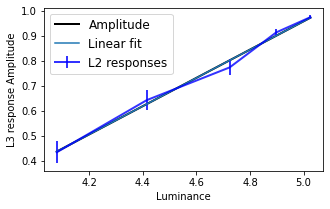

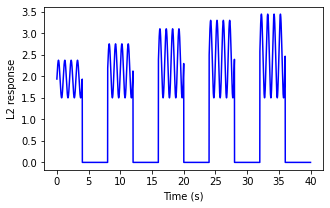

In [38]:
# Stimuli parameters
#--- time ----
dt_st = 0.001   # Time window in s.
T_max_st = 4.0  # Epoch duration in s.
T_min_st = 0
Nt_st = round((T_max_st - T_min_st)/dt_st)
Omega_st = 1    # Stimulus Frequency (radians per sec)
C0 = 10      # Stimulus Contrast
#--- space ----
dx_st = 0.5
x_min_st = 0
x_max_st = 80  #Screen size (80 degrees)
Nx_st = int((x_max_st - x_min_st)/dx_st)
Nx_st_half =  int((x_max_st - x_min_st)/2)
Omega_st_s = 1/10 # Stimulus spatial frequency (Units: radians per Degrees)
space_array_st = np.arange(x_min_st, x_max_st, dx_st)

#--- Luminance ----
L0_exp_min = 1.2E4
L0_exp_max = 10.6E4
L0_array = np.array([L0_exp_min, 2.6E4, 5.3E4, 7.9E4, L0_exp_max])
Nl = L0_array.size

# Model parameters
Stim_circular_array = np.array([5, 10, 12, 15, 18, 20, 25, 30, 35]) # Diameter of the stimulus (Degrees)
Nstim = Stim_circular_array.size
N_ite = 1000
Circular_pooling_array = np.array([20])
baseline = 1.5 # of L3 Scanned from plots. Not relevant for the analysis.
Total_time_array_st = np.arange(T_min_st, T_max_st*Nl*2, dt_st) 

#------ L3 neurons -----------
Slope_L3, Cut_L3, L3_time, L3_time_epochs = L3_neurons()
Visualize_L3()

Circular_pooling_size = Circular_pooling_array[0]

# #-------- Tm1 -------------------
#g0 = 0.3 # Base conductance. 
#ExpNum = 1 # Linear in the numerator.
#ExpDen = 1 # linear den normalization.
#alpha = 1
#alpha_norm = 2. # Normalization weight.
#alpha_norm = 0 # Without Normalization weight.

# g0 = 0.005 # Base conductance. 
# ExpNum = 1 # Linear in the numerator.
# ExpDen = 1 # Linear den normalization.
# alpha_l3 = 1
# #alpha_norm = 1.5 # Normalization weight.
# alpha_norm = 0 # Without Normalization weight.
# L3_num = 0.6*L0_array[0]
# #lum_alpha = (0.25**0.48)

#Respomse_Tm9_time, Amplitude = Normalization_L3()
#Visualize_normalization_space()

#-------- Tm9 and Tm1 -------------------
ExpNum = 1 # Linear in the numerator.
ExpDen = 2 # Tm9: Quadratic den normalization. Tm1: Linear den normalization

if ExpDen == 2:
    #--- Parameters ---
    g0 = 0.005 # Base conductance. 
    alpha_l3 = 1
    alpha_norm = 1.5 # Normalization weight.
    #alpha_norm = 0 # Without Normalization weight.
    L3_num = 0.6*L0_array[0]
    
    Respomse_Tm9_time, Amp_Tm9_model_ = Normalization_L3() 
    Amplitude = np.copy(Amp_Tm9_model_)
else: 
    #--- Parameters ---
    g0 = 0.05 # Base conductance. 
    alpha_l3 = 1
    alpha_norm = 1.5 # Normalization weight.
    #alpha_norm = 0 # Without Normalization weight.
    L3_num = 0.2*L0_array[0]
    
    Respomse_Tm9_time, Amp_Tm1_model_ = Normalization_L3() 
    Amplitude = np.copy(Amp_Tm1_model_)
    

(1000, 5, 9, 4000) (40000,)


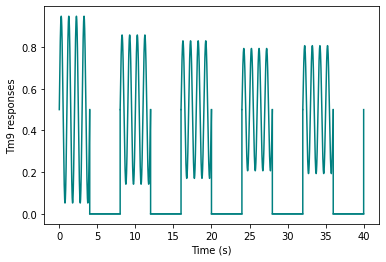

In [34]:
print(Respomse_Tm9_time.shape, Total_time_array_st.shape)
counter = -1
for i_l0 in range(Nl):
    counter += 1
    time_ =  Total_time_array_st[counter*4000: counter*4000 + 4000]
    plt.plot(time_, Respomse_Tm9_time[0,i_l0,5,:] + 0.5, color = 'teal')
    counter += 1
    time_ =  Total_time_array_st[counter*4000: counter*4000 + 4000]
    plt.plot(np.append(np.array([time_[0]]),time_), np.append(0.5, np.zeros(4000)), color = 'teal')
    plt.plot(np.append(time_,np.array([time_[-1]])), np.append(np.zeros(4000), 0.5), color = 'teal')
plt.xlabel("Time (s)")
plt.ylabel("Tm9 responses")
if ExpDen == 1:
    plt.savefig("Plots/Tm1_traces_example.pdf", bbox_inches = 'tight', dpi = 300)
else:
    plt.savefig("Plots/Tm9_traces_example.pdf", bbox_inches = 'tight', dpi = 300)

In [ ]:
Fig = plt.figure(figsize = (5, 3))
plt.plot(Total_time_array_st, L3_time, color = 'g')
plt.xlabel("Time (s)")
plt.ylabel("L3 response")
#plt.savefig("Plots/L3_traces_"+str(string_plot[norm_par])+".pdf", bbox_inches = 'tight', dpi = 300)
plt.show() 

(5, 117)


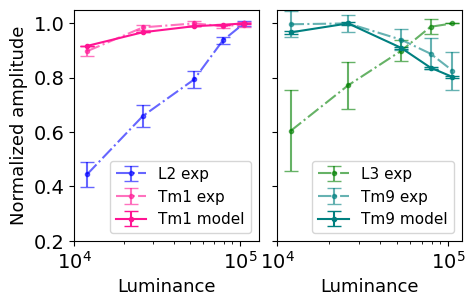

In [10]:
#---- First Plot paper -----
norm_par = 0
if alpha_norm != 0:
    norm_par = 1
#Visualize_Tm9_responses_time(7, 0, 0, norm_par) #i_Nstim, i_Nite, savepar: If save Fig a sa new plot, norm_par: 0 if no norm; 1 otherwise 

Amp_Tm9_exp_= np.loadtxt("Data/Tm9_Amp_exp.txt") #From experiments. 
Amp_Tm1_exp_ = np.loadtxt("Data/Tm1_Amp_exp.txt") #From experiments.
Amp_L2_exp_ = np.loadtxt("Data/L2_Amp_exp.txt") #From experiments.
Amp_L3_exp_ = np.loadtxt("Data/L3_Amp_exp.txt") #From experiments.

print(Amp_L2_exp_.shape)

Amp_Tm9_exp = unumpy.uarray(np.mean(Amp_Tm9_exp_, axis = 1), np.std(Amp_Tm9_exp_, axis = 1)**2)
Amp_Tm9_exp /= unumpy.nominal_values(np.max(Amp_Tm9_exp))
Amp_Tm1_exp = unumpy.uarray(np.mean(Amp_Tm1_exp_, axis = 1), np.std(Amp_Tm1_exp_, axis = 1)**2)
Amp_Tm1_exp /= unumpy.nominal_values(np.max(Amp_Tm1_exp))
Amp_L2_exp = unumpy.uarray(np.mean(Amp_L2_exp_, axis = 1), np.std(Amp_L2_exp_, axis = 1)**2)
Amp_L2_exp /= unumpy.nominal_values(np.max(Amp_L2_exp))
Amp_L3_exp = unumpy.uarray(np.mean(Amp_L3_exp_, axis = 1), np.std(Amp_L3_exp_, axis = 1)**2)
Amp_L3_exp /= unumpy.nominal_values(np.max(Amp_L3_exp))
i_stim_size = 6
Amp_Tm9_model = unumpy.uarray(np.mean(Amp_Tm9_model_[:,:,i_stim_size], axis = 0), np.std(Amp_Tm9_model_[:,:,i_stim_size], axis = 0)**2)
Amp_Tm9_model /= unumpy.nominal_values(np.max(Amp_Tm9_model))
i_stim_size = 8
Amp_Tm1_model = unumpy.uarray(np.mean(Amp_Tm1_model_[:,:,i_stim_size], axis = 0), np.std(Amp_Tm1_model_[:,:,i_stim_size], axis = 0)**2)
Amp_Tm1_model /= unumpy.nominal_values(np.max(Amp_Tm1_model))


# Just create here a subplots fig. 

fig, ax = plt.subplots(1,2, figsize = (5, 3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.2)

ax[0].errorbar(L0_array, unumpy.nominal_values(Amp_L2_exp), yerr = unumpy.std_devs(Amp_L2_exp), color = 'blue', linestyle = '-.', marker = '.', capsize = 5, label = 'L2 exp', alpha = 0.6)
ax[1].errorbar(L0_array, unumpy.nominal_values(Amp_L3_exp), yerr = unumpy.std_devs(Amp_L3_exp), color = 'green', linestyle = '-.', marker = '.', capsize = 5, label = 'L3 exp', alpha = 0.6)
ax[1].errorbar(L0_array, unumpy.nominal_values(Amp_Tm9_exp), yerr = unumpy.std_devs(Amp_Tm9_exp), color = 'teal', linestyle = '-.', marker = '.', capsize = 5, label = 'Tm9 exp', alpha = 0.6)
ax[0].errorbar(L0_array, unumpy.nominal_values(Amp_Tm1_exp), yerr = unumpy.std_devs(Amp_Tm1_exp), color = 'deeppink', linestyle = '-.', marker = '.', capsize = 5, label = 'Tm1 exp', alpha = 0.6)
#plt.plot(L0_array, np.log10(L0_array)*Slope_L3 + Cut_L3, color = 'green', marker = '.', label = 'L3 model', alpha = 0.6)
ax[1].errorbar(L0_array, unumpy.nominal_values(Amp_Tm9_model), yerr = unumpy.std_devs(Amp_Tm9_model), color = 'teal', marker = '.', capsize = 5, label = 'Tm9 model')
ax[0].errorbar(L0_array, unumpy.nominal_values(Amp_Tm1_model), yerr = unumpy.std_devs(Amp_Tm1_model), color = 'deeppink', marker = '.', capsize = 5, label = 'Tm1 model')
ax[0].set_xscale('log')
ax[0].set_xlabel("Luminance", fontsize = 13)
ax[0].set_ylabel("Normalized amplitude", fontsize = 13)
ax[0].set_xlim(10E3, 13E4)
ax[0].set_ylim(0.2, 1.05)
ax[0].tick_params(labelsize = 14)
ax[0].legend(fontsize = 11, loc = 4)
ax[1].set_xscale('log')
ax[1].set_xlabel("Luminance", fontsize = 13)
#ax[0].set_ylabel("Normalized amplitude response", fontsize = 13)
ax[1].set_xlim(10E3, 12E4)
ax[1].set_ylim(0.2, 1.05)
ax[1].tick_params(labelsize = 14)
ax[1].legend(fontsize = 11, loc = 4)
ax[1].set_yticklabels([])
plt.savefig("Plots/Amplitudes_ExpPlusModel_split.pdf", bbox_inches = 'tight', dpi = 300, format = 'pdf')

Parameters used for the plot


- #--- TM9 Parameters ---

g0 = 0.005 # Base conductance.

alpha_l3 = 1

alpha_norm = 1.5 # Normalization weight.

#alpha_norm = 0 # Without Normalization weight.

L3_num = 0.6*L0_array[0]


- #--- TM1 Parameters ---
g0 = 0.05 # Base conductance. 

alpha_l3 = 1

alpha_norm = 1.5 # Normalization weight.

#alpha_norm = 0 # Without Normalization weight.

L3_num = 0.2*L0_array[0]
